In [11]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_set = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_set = datasets.MNIST(
    root='./data',
    train=False,
    download=False,
    transform=ToTensor()
)

In [13]:
batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [14]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.layer0 = nn.Linear(input_size, hidden_size, bias=True)
        self.layer1 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.layer2 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.layer3 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.layer4 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.layer5 = nn.Linear(hidden_size, output_size, bias=True)
        
    def forward(self, x):
        # Assuming x is a tensor with size (batch_size, 1, 28, 28)
        batch_size, _, height, width = x.size()

        # Flatten the input tensor
        x = x.view(batch_size, -1)

        x = nn.functional.relu(self.layer0(x))
        x = nn.functional.relu(self.layer1(x))
        x = nn.functional.relu(self.layer2(x))
        x = nn.functional.relu(self.layer3(x))
        x = nn.functional.relu(self.layer4(x))
        x = self.layer4(x)
        return x

In [15]:
# Do not change this cell
def caluculate_acc(data, model, length):
  model.eval()
  acc = 0
  for images, label in data:
    with torch.no_grad():
      images = images.to(device)
      label = label.to(device)
      yp = model(images)
      yp = torch.nn.functional.softmax(yp, dim=1)
      yp = torch.argmax(yp, 1)
      acc += torch.sum(yp == label)
  return acc / length

In [16]:
# Do not change this cell
def train_one_epoch(model, data, optimizer, criterion, length):
  model.train()
  acc = 0
  for images, labels in data:
    imgs = torch.autograd.Variable(images).to(device)
    label = torch.autograd.Variable(labels).to(device)
    optimizer.zero_grad()
    yp = model(imgs)
    loss = criterion(yp, label)
    loss.backward()
    optimizer.step()
    yp = torch.argmax(yp, 1)
    acc += torch.sum(yp == label)
  return loss.item(), acc / length

In [17]:
model = model = Model(input_size=784, hidden_size=100, output_size=10).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

criterion = nn.CrossEntropyLoss()

# model summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          78,500
            Linear-2                  [-1, 100]          10,100
            Linear-3                  [-1, 100]          10,100
            Linear-4                  [-1, 100]          10,100
            Linear-5                  [-1, 100]          10,100
            Linear-6                  [-1, 100]          10,100
Total params: 129,000
Trainable params: 129,000
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.49
Estimated Total Size (MB): 0.50
----------------------------------------------------------------


In [18]:
# training process
val_accs = []
accs = []
best_acc = 0
for e in tqdm(range(20)):
  accs.append(train_one_epoch(model, train_loader, optimizer, criterion, len(train_set))[1].item())
  val_accs.append(caluculate_acc(test_loader, model, len(test_set)).item())
  if best_acc < val_accs[-1]:
    torch.save(model, "model.h5")
    best_Acc = val_accs[-1]
  
  # just a way to avoid pverfitting
  if val_accs[-1] > 0.99 and accs[-1] > 0.99:
    break

  0%|          | 0/20 [00:00<?, ?it/s]

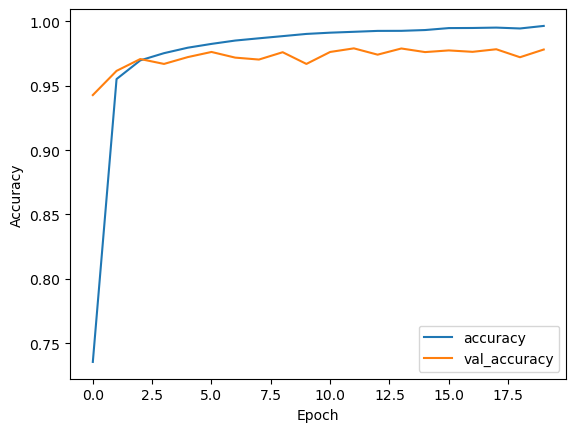

In [19]:
plt.plot(accs, label='accuracy')
plt.plot(val_accs, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show();

In [20]:
caluculate_acc(test_loader, model, len(test_set)).item(), caluculate_acc(train_loader, model, len(train_set)).item()

(0.9782000184059143, 0.994700014591217)